# Forecasting France’s Electricity Consumption (D+1 at noon on D)

**Goal:** At **12:00 on day _N_ (Europe/Paris)**, predict **total electricity consumption for day _N+1_**.

---

## Problem Framing & Constraints

- **Information cut-off at noon:** Use partial load on day _N_ from **00:00→12:00**; no access to afternoon/evening of _N_.
- **Next-day weather available:** Use **forecasts for day _N+1_** (during training, observed temps act as a “perfect forecast” proxy).
- **Calendar effects:** Day-of-week, weekends, French public holidays, annual seasonality.

---

## Data & Feature Engineering

**Load (RTE, 30-min, tz-aware Europe/Paris):**
- Daily total MWh.
- **Partial-day load** `Y_D_partial`: cumulative MWh from **00:00→12:00** on day _N_.

**Temperature (daily, midnight index):**
- Base: `tmin`, `tmax`, `tmean`.
- Smoothed features via EMA: `temp95`, `temp99`, `tempmin99`, `tempmax99`.

**Calendar:**
- `dow`, `is_weekend`, `is_holiday` (France).
- Seasonal position `toy = (day_of_year − 1)/365`.
- For CatBoost: cyclical bases `dow_sin/cos` (period 7) and `doy_sin/cos` (period 365).

**Recent levels (known by noon on _N_):**
- Lags of daily total: `Y_Dm1`, `Y_Dm2`, `Y_Dm3`, `Y_Dm7`.

**Training target:** For a row indexed by day **t**, the target is **`Y_{t+1}`** (next-day total).

---

## Train / Test Protocol

- **Training window:** **2018–2023** (excluding 2020, due to change in consumption with COVID lockdown).
- **Test window:** **2024**, out-of-sample.
- **Leakage control:** Each feature vector uses information available **by noon on day _t_** (partial load, historical lags, and forecast for _t+1_).  
  For ARIMAX, produce **two-step forecasts** per origin (exog at _t−1_ and _t_), keeping the **second** step `Y_{t+1}`.

**Metrics:** MAE, RMSE, MAPE, WAPE (daily granularity).

---

## Four Forecasters Baseline (Experts)

1. **ARIMAX (SARIMAX)**
   - Endog: `y_t = Y_{t+1}` (daily).
   - Exog: features above with `t*_fc` aligned to `t+1`.
   - Weekly seasonality (7).
   - **Noon** logic via **2-step ahead** forecasting per origin.

2. **Linear Regression (OLS)**
   - Same features; optional standardization.
   - Optional linear interaction `tmean_fc × toy` (proxy for tempXseason effects).

3. **GAM (pyGAM LinearGAM)**
   - Smooth terms for temperatures and cyclic seasonality (`toy`).
   - Smooth terms for partial and lagged loads.

4. **CatBoost Regressor**
   - Cyclical `dow_sin/cos`, `doy_sin/cos`.
   - `t*_fc` temps, partial/lagged loads, weekend/holiday flags.
   - Chronological early stopping.

All forecasters use a unified interface:
```python
predict_one_day(date_D, load_30min, temp_forecast) -> float
```

## Online Ensembling with OPERA

**Why online?** Decisions are made sequentially (day by day). OPERA’s  [3] **BOA/MLpol** online learner **adapts expert weights** after each observed day, hedging across models as regimes change (cold spells, holidays, demand shifts).

**Process per day D in 2024:**
1. Gather the four experts’ predictions for **`Y_{D+1}`**.
2. Feed this vector to OPERA’s `Mixture` (`model= "BOA" or "MLpol"`, `loss_type="mse"`).
3. **Predict ensemble** → observe `Y_{D+1}` → **update** mixture (weights).
4. Repeat next day.

**Implementation notes:**
- Initialize `Mixture` with empty history but the **correct expert column names**.
- Stream **one row per day**: `predict(one_row_df)` then `update(row_df, true_series)`.
- If OPERA is unavailable, fall back to **Exponentially Weighted Average** with squared loss (same interface).

---

## Backtesting Logic for 2024

**Valid origins D** satisfy:
- Load available for **D−1**, **D** (features) and **D+1** (truth).
- Temperature rows exist for **D** and **D+1** (midnight).
- All indices **tz-aware (Europe/Paris)** and aligned to midnight.

**At each D:**
- Call every expert’s `predict_one_day(D, load_2024, temp_all)`.
- OPERA produces the **ensemble**.
- Record `true = daily_total[D+1]`.  
Compute **MAE/RMSE/MAPE/WAPE** over the full 2024 horizon.

---

## Results (Summary)

In our runs, the **OPERA ensemble** achieves **the best overall error** (e.g., lowest RMSE/WAPE), with **GAM** close behind and **CatBoost** outperforming simpler linear/ARIMAX baselines. Exact numbers vary with data cut and temperature coverage, but the pattern **ensemble ≤ best single expert** is consistent with the literature.

## References
> [1] Obst, D.; de Vilmarest, J.; Goude, Y.
> Adaptive Methods for Short-Term Electricity Load Forecasting During COVID-19 Lockdown in France. 
> IEEE Trans. Power Systems 36(5): 4754–4763. (2021). 

> [2] de Vilmarest, J., & Goude, Y.
> State-Space Models for Online Post-Covid Electricity Load Forecasting Competition. 
> IEEE Open Access Journal of Power and Energy, 9, 192–201.  (2022). 

> [3] Gaillard, P., Goude, Y., Plagne, L., Dubois, T., & Thieurmel, B.  
> opera: Online Prediction by Expert Aggregation. R package version 1.2.0. 
> Available on CRAN. (2021).


# Interactive Training and Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd

current_dir = os.getcwd()
parent_dir  = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.helpers import load_rte_data, halfhour_to_daily_mwh, load_temperature
from src.forecasters.gam import GAMConfig, GAMForecaster
from src.forecasters.arimax import ARIMAConfig, ARIMAForecaster
from src.forecasters.linear import LRConfig, LinearRegForecaster
from src.forecasters.catboost import CatBoostConfig, CatBoostForecaster
from src.ensembler.opera_ensembler import OperaStackConfig, OperaStackEnsembler

## Individual Forecaster Training

In [2]:
# Load train data
train_df = load_rte_data("../data/load_rte/", from_year=2018, to_year=2023)
temperature = load_temperature("../data/temp/")

/home/I50280/FrenchLoadForecast/src/utils/helpers.py:120: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + f"{year}.csv")


In [3]:
arxcfg = ARIMAConfig()
arx = ARIMAForecaster(arxcfg)
arx.fit(train_df, temperature)

lrcfg = LRConfig()
lf = LinearRegForecaster(lrcfg)
lf.fit(train_df, temperature)

gamcfg = GAMConfig()
gf = GAMForecaster(gamcfg)
gf.fit(train_df, temperature)

cbcfg = CatBoostConfig()
cb = CatBoostForecaster(cbcfg)
cb.fit(train_df, temperature)

/home/I50280/FrenchLoadForecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/I50280/FrenchLoadForecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
2025-10-12 15:45:11,012 - INFO - Fitted LinearRegForecaster: 1817 samples, RMSE=74077.335
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:08 ETA:   0:01:22
 18% (2 of 11) |####                     | Elapsed Time: 0:00:16 ETA:   0:01:13
 27% (3 of 11) |######                   | Elapsed Time: 0:00:23 ETA:   0:01:03
 36% (4 of 11) |#########                | Elapsed Time: 

In [4]:
# Ensemble of trained forecasters
predictors = [("arimax", arx), ("linreg", lf), ("gam", gf), ("catboost", cb)]

In [5]:
# Load test dataframe (30min sampled data): we keep 2023 as we need the lag of the last month
test_df = load_rte_data('../data/load_rte/', from_year=2023, to_year=2024)

## Prediction

We start with a simple one day prediction aheaded training set values (January 1st 2024)

In [6]:
# Prediciton
day_to_forecast = pd.Timestamp("2023-12-31", tz="Europe/Paris")

Dplus1 = day_to_forecast + pd.Timedelta(days=1)
test_daily = halfhour_to_daily_mwh(test_df, col="load_mw_30min")

y_true = float(test_daily.loc[Dplus1])

# Collect predictions
rows = []
for name, model in predictors:
    yhat = float(model.predict_one_day(day_to_forecast, test_df, temperature))
    err = yhat - y_true
    rows.append({
        "model": name,
        "prediction": yhat,
        "abs_error": abs(err),
        "pct_error": (abs(err) / y_true) if y_true != 0 else np.nan,
    })

df = pd.DataFrame(rows).set_index("model").sort_values("abs_error")

# Nice numeric formatting
fmt = {
    "prediction": "{:,.0f}".format,
    "abs_error": "{:,.0f}".format,
    "pct_error": lambda x: f"{x:.2%}" if pd.notnull(x) else "—",
}

# Display block
print(f"Forecast made on D = {day_to_forecast.date()}  →  Target day D+1 = {Dplus1.date()}")
print(f"True total MWh (D+1): {y_true:,.0f}\n")

display(df)

Forecast made on D = 2023-12-31  →  Target day D+1 = 2024-01-01
True total MWh (D+1): 1,235,656



,prediction,abs_error,pct_error
model,,,
linreg,1.303282e+06,67626.290346,0.054729
arimax,1.344559e+06,108903.329558,0.088134
gam,1.353393e+06,117736.634139,0.095283
catboost,1.374438e+06,138781.643523,0.112314


We then forecast on the entire 2024 year

In [7]:
date_start_pred = "2024-01-01"
date_end_pred   = "2024-12-31"


test_daily = halfhour_to_daily_mwh(test_df, col="load_mw_30min")
daily_mwh = test_daily.loc[(test_daily.index >= pd.Timestamp(date_start_pred, tz="Europe/Paris") - pd.Timedelta(days=1)) &
                          (test_daily.index <= pd.Timestamp(date_end_pred, tz="Europe/Paris"))]

# Build valid origins D:
# need D-1 and D available for features, and D+1 for truth.
all_days = daily_mwh.index.sort_values()
valid_D = []
for D in all_days:
    Dm1 = D - pd.Timedelta(days=1)
    Dp1 = D + pd.Timedelta(days=1)
    if Dm1 in all_days and D in all_days and Dp1 in daily_mwh.index:
        # also require temps for D and D+1 exist in the temp frame
        # (temp loader should return daily midnights with tmin/tmax/tmean)
        if (D in temperature.index) and (Dp1 in temperature.index):
            valid_D.append(D)

# To avoid leaking into 2025 when truth is 2025-01-01, keep targets strictly in 2024
valid_D = [D for D in valid_D if (D + pd.Timedelta(days=1)).year == 2024]
valid_D = pd.DatetimeIndex(valid_D).tz_convert(tz="Europe/Paris")

# Evaluate
rows = []
for name, model in predictors:
    preds = []
    for D in valid_D:
        yhat = model.predict_one_day(D, test_df, temperature)
        ytrue = float(daily_mwh.loc[D + pd.Timedelta(days=1)])
        preds.append((D, yhat, ytrue))
    pred_df = pd.DataFrame(preds, columns=["D", "pred", "true"]).set_index("D").sort_index()
    pred_df["abs_err"] = (pred_df["pred"] - pred_df["true"]).abs()
    pred_df["ape"] = pred_df["abs_err"] / pred_df["true"].replace(0, np.nan)

    mae  = float(pred_df["abs_err"].mean())
    rmse = float(np.sqrt(((pred_df["pred"] - pred_df["true"])**2).mean()))
    wape = float(pred_df["abs_err"].sum() / pred_df["true"].sum())
    mape = float(np.nanmean(pred_df["ape"]))

    pred_df["model"] = name
    rows.append((name, pred_df, {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE": mape}))

# Concatenate predictions from all models
preds_all = pd.concat([r[1] for r in rows], axis=0).sort_index()
metrics   = {r[0]: r[2] for r in rows}

print("=== TEST METRICS ===")
for m, d in metrics.items():
    print(f"{m:9s}  MAE={d['MAE']:.2f}  RMSE={d['RMSE']:.2f}  WAPE={100*d['WAPE']:.2f}%  MAPE={100*d['MAPE']:.2f}%")

=== TEST METRICS ===
arimax     MAE=69379.39  RMSE=91776.55  WAPE=5.78%  MAPE=6.25%
linreg     MAE=52675.62  RMSE=64813.33  WAPE=4.39%  MAPE=4.59%
gam        MAE=19752.15  RMSE=29799.07  WAPE=1.65%  MAPE=1.67%
catboost   MAE=23016.58  RMSE=34808.34  WAPE=1.92%  MAPE=1.88%


### Ensemble online prediction (with OPERA)

In [8]:
date_start_pred = "2024-01-01"
date_end_pred   = "2024-12-31"

ens = OperaStackEnsembler(OperaStackConfig(model="MLpol")) # MLpol or BOA
mix, preds_df, metrics = ens.evaluate_2024(predictors, 
                                            test_df, 
                                            temperature,
                                            date_start_online_pred=date_start_pred,
                                            date_end_online_pred=date_end_pred)

/home/I50280/FrenchLoadForecast/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/I50280/FrenchLoadForecast/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Forecast table summary

In [9]:
preds_df.head()

,arimax,linreg,gam,catboost,ensemble,true
2024-01-01 00:00:00+01:00,1.365429e+06,1.326218e+06,1.371083e+06,1.367701e+06,1.357608e+06,1357899.5
2024-01-02 00:00:00+01:00,1.329526e+06,1.331061e+06,1.326204e+06,1.344093e+06,1.332948e+06,1376992.0
2024-01-03 00:00:00+01:00,1.398559e+06,1.314280e+06,1.391010e+06,1.388693e+06,1.388693e+06,1390729.0
2024-01-04 00:00:00+01:00,1.449477e+06,1.387766e+06,1.468455e+06,1.448097e+06,1.448097e+06,1422006.5
2024-01-05 00:00:00+01:00,1.477291e+06,1.389142e+06,1.421420e+06,1.399295e+06,1.393254e+06,1390673.0


Mixture summary

/home/I50280/FrenchLoadForecast/src/ensembler/opera.py:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(alabels[idx], rotation=90)


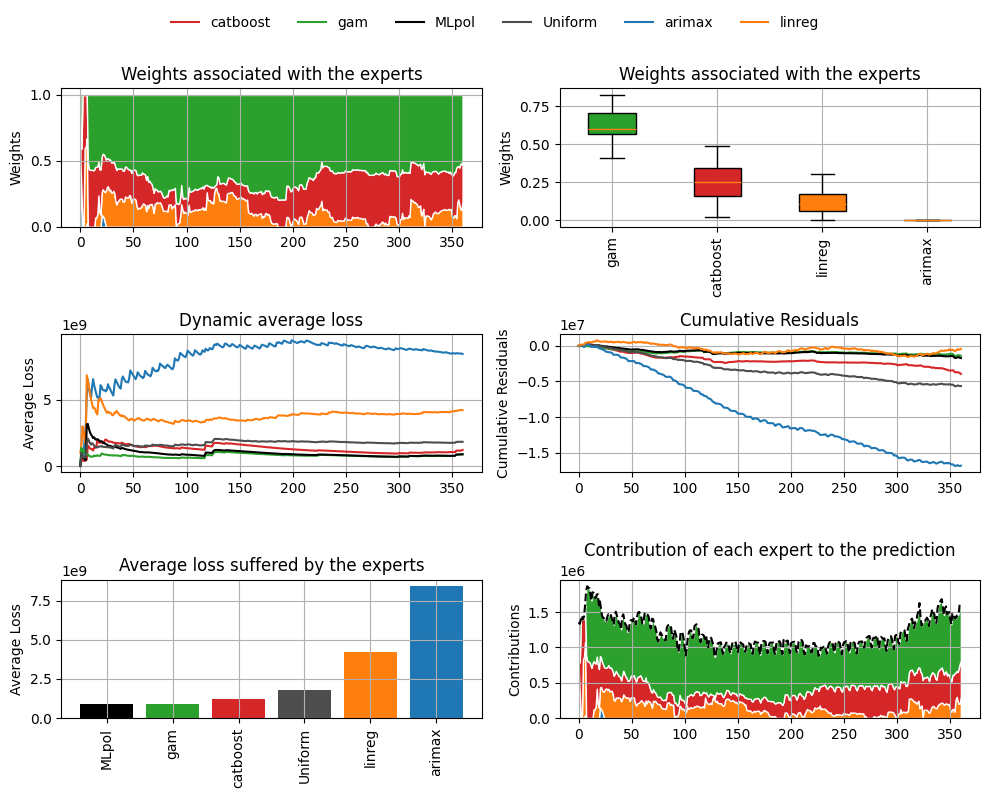

In [10]:
mix.plot_mixture()

Mixture's weights summary

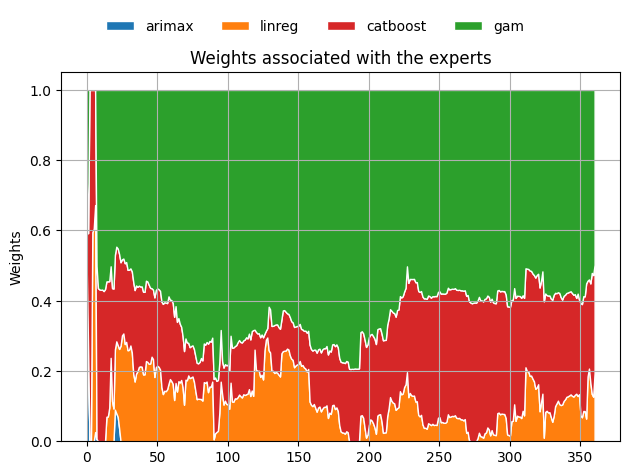

In [11]:
mix.plot_mixture(plot_type="plot_weight")

### Results vizualisation

In [12]:
from src.utils.plot import (
    plot_forecast_all_model,
    plot_scatter_true_vs_preds,
    plot_forecast_error,
    plot_monthly_mae_error,
    plot_metrics_bars
)
from src.utils.helpers import overall_metrics

Full horizon prediction vs true values

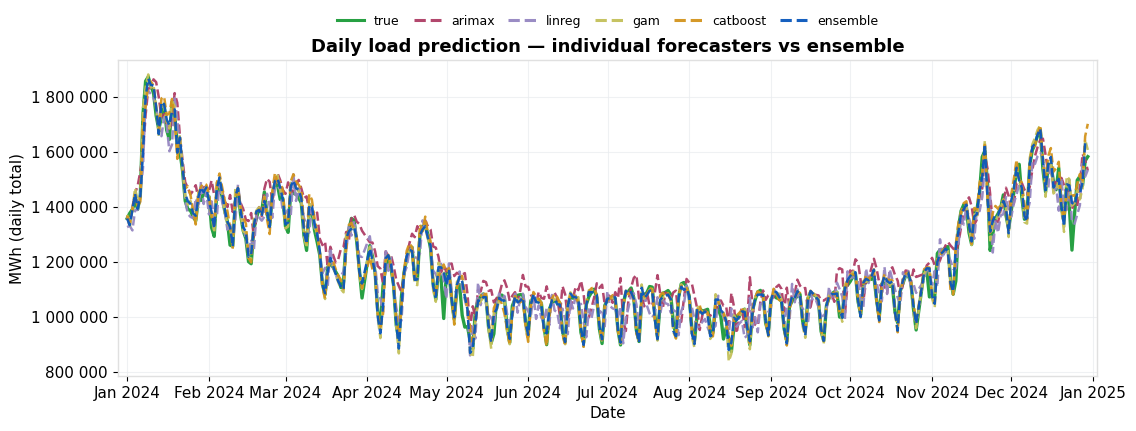

In [13]:
plot_forecast_all_model(preds_df)

Scatter plot error for the entire test set

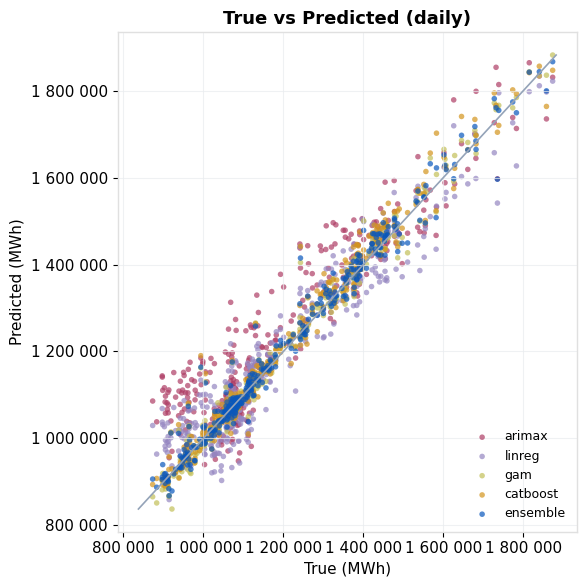

In [14]:
plot_scatter_true_vs_preds(preds_df)

MAE forecasting error for each baseline according to time

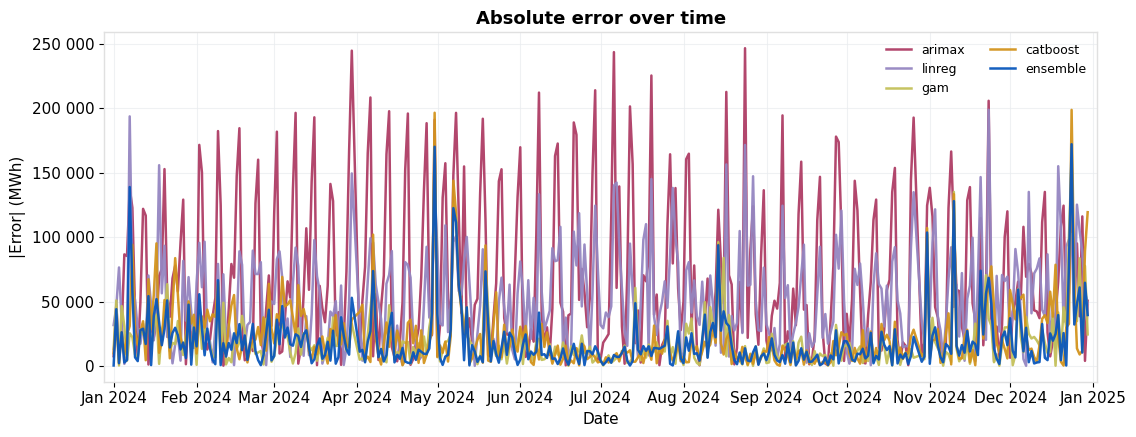

In [15]:
plot_forecast_error(preds_df)

Monthy aggregated error

/home/I50280/FrenchLoadForecast/src/utils/plot.py:555: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df.index.to_period("M").astype(str)


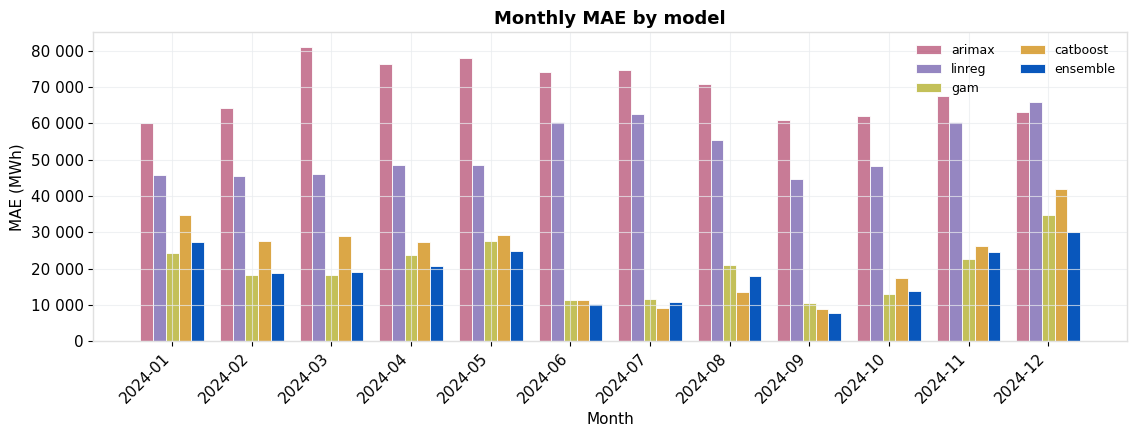

In [16]:
plot_monthly_mae_error(preds_df)

Metric summary benchmark

In [17]:
metrics = overall_metrics(preds_df, models=["arimax","linreg","gam","catboost","ensemble"])

In [18]:
metrics

,MAE,RMSE,MAPE,WAPE
model,,,,
ensemble,18862.309664,29728.666617,0.015789,0.015717
gam,19752.148260,29799.065818,0.016750,0.016458
catboost,23016.580299,34808.339676,0.018842,0.019178
linreg,52675.624328,64813.328359,0.045883,0.043892
arimax,69379.390043,91776.554921,0.062456,0.057810


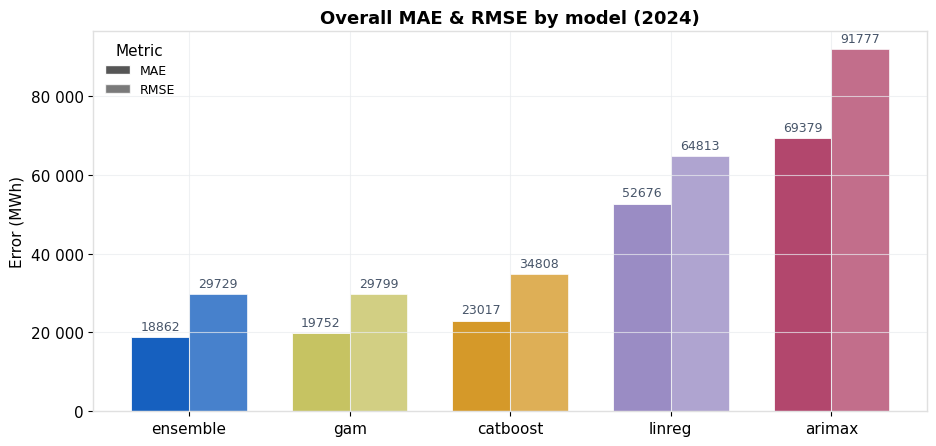

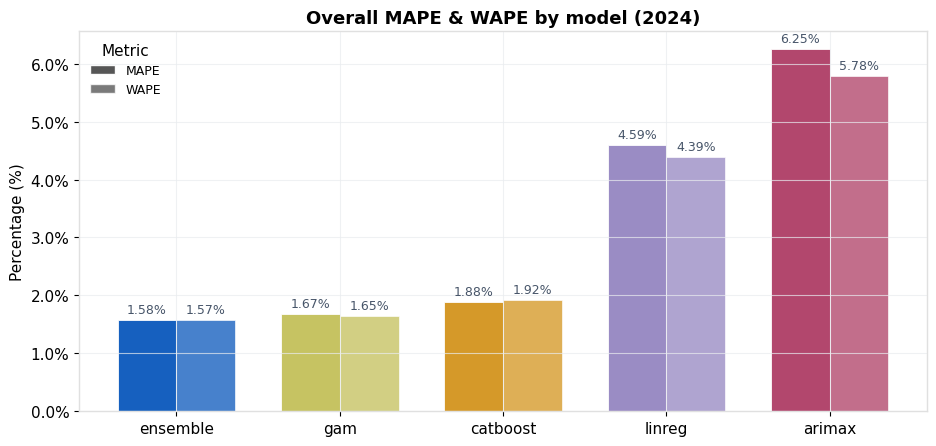

In [19]:
plot_metrics_bars(metrics=metrics)